In [1]:
# Import Python modules
from __future__ import division
import numpy as np
import sklearn.datasets as skl
import matplotlib.pyplot as plt
from multiprocessing import Pool
import timeit
from sklearn.cluster import KMeans



class K_Means(object):
    # Initialize input values n_clusters and max_iter
    def __init__(self, n_clusters, max_iter):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    # Function that assigns points to a cluster
    def assign_points_to_cluster(self, X):
        # Label points according to the minimum euclidean distance
        self.labels_ = [self._nearest(self.cluster_centers_, x) for x in X]
        # Map labels to data points
        indices=[]
        for j in range(self.n_clusters):
            cluster=[]
            for i, l in enumerate(self.labels_):
                if l==j: cluster.append(i)
            indices.append(cluster)
        X_by_cluster = [X[i] for i in indices]
        return X_by_cluster

    # Function that randomly selects initial centroids
    def initial_centroid(self, X):
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        return X[initial]

    # Function that updates centroids and repeats
    # assign_points_to_cluster until convergence or max_iter is reached
    def fit(self, X):
        # initialize centroids
        self.cluster_centers_ = self.initial_centroid(X)
        # process of assigning points to clusters until convergence or until max_iter is reached
        for i in range(self.max_iter):
            X_by_cluster = self.assign_points_to_cluster(X)
            # calculate the new centers
            new_centers=[c.sum(axis=0)/len(c) for c in X_by_cluster]
            new_centers = [arr.tolist() for arr in new_centers]
            old_centers=self.cluster_centers_
            # if the new centroid are the same as the old centroids then the algorithm has converged
            if np.all(new_centers == old_centers):
                self.number_of_iter=i
                break;
            else:
                # set self.cluster_centers_ as new centers
                self.cluster_centers_ = new_centers
        self.number_of_iter=i
        return self

    # Function that calculates the minimum euclidean distance
    def _nearest(self, clusters, x):
        return np.argmin([self._distance(x, c) for c in clusters])

    # Function to calculate euclidean distance between two points
    def _distance(self, a, b):
        return np.sqrt(((a - b)**2).sum())

    # Function that returns predicted clusters for each point
    def predict(self, X):
        return self.labels_

In [2]:
sim1 = []

TEST_CODE1 = """
kmeans = K_Means(n_clusters = 3, max_iter = 50)
kmeans.fit(X)
"""

SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=50, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means
"""
sim1.append(timeit.timeit(stmt=TEST_CODE1,setup=SETUP_CODE,number=50)/50)
print ("1")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means
"""
sim1.append(timeit.timeit(stmt=TEST_CODE1,setup=SETUP_CODE,number=50)/50)
print ("2")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=500, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means
"""
sim1.append(timeit.timeit(stmt=TEST_CODE1,setup=SETUP_CODE,number=50)/50)
print ("3")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=1000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means
"""
sim1.append(timeit.timeit(stmt=TEST_CODE1,setup=SETUP_CODE,number=50)/50)
print ("4")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=2000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means
"""
sim1.append(timeit.timeit(stmt=TEST_CODE1,setup=SETUP_CODE,number=50)/50)
print ("5")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=5000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means
"""
sim1.append(timeit.timeit(stmt=TEST_CODE1,setup=SETUP_CODE,number=50)/50)
print ("6")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=10000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means
"""
sim1.append(timeit.timeit(stmt=TEST_CODE1,setup=SETUP_CODE,number=50)/50)
print ("7")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=20000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means
"""
sim1.append(timeit.timeit(stmt=TEST_CODE1,setup=SETUP_CODE,number=50)/50)
print ("8")

1
2
3
4
5
6
7
8


In [3]:
import pandas as pd

# Creating a dataframe with the results
results1 = pd.DataFrame(sim1)

In [4]:
# Import Python modules
from __future__ import division
import numpy as np
from multiprocessing import Pool
import timeit



class K_Means_parallel(object):
    # Initialize input values n_clusters and max_iter
    def __init__(self, n_clusters, max_iter, num_cores):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.num_cores = num_cores

    # Function that assigns points to a cluster
    def assign_points_to_cluster(self, X):
        # Label points according to the minimum euclidean distance
        self.labels_ = [self._nearest(self.cluster_centers_, x) for x in X]
        # Map labels to data points
        indices=[]
        for j in range(self.n_clusters):
            cluster=[]
            for i, l in enumerate(self.labels_):
                if l==j: cluster.append(i)
            indices.append(cluster)
        X_by_cluster = [X[i] for i in indices]
        return X_by_cluster

    # Function that randomly selects initial centroids
    def initial_centroid(self, X):
        initial = np.random.permutation(X.shape[0])[:self.n_clusters]
        return  X[initial]

    # Function that updates centroids and repeats
    # assign_points_to_cluster until convergence or max_iter is reached
    def fit(self, X):
        self.cluster_centers_ = self.initial_centroid(X)
        for i in range(self.max_iter):
            # split data to self.num_cores chunks
            splitted_X=self._partition(X,self.num_cores)
            # Parallel Process for assigning points to clusters
            p=Pool()
            result=p.map(self.assign_points_to_cluster, splitted_X )
            p.close()
            # Merge results
            p.join()
            X_by_cluster=[]
            for c in range(0,self.n_clusters):
                r=[]
                for p in range(0,self.num_cores):
                    tmp=result[p][c].tolist()
                    r=sum([r, tmp ], [])
                X_by_cluster.append(np.array(r))
            # calculate the new centers
            new_centers=[c.sum(axis=0)/len(c) for c in X_by_cluster]
            new_centers = [np.array(arr) for arr in new_centers]
            old_centers=self.cluster_centers_
            old_centers = [np.array(arr) for arr in old_centers]
            # if the new centroids are the same as the old centroids then
            # the algorithm has converged
            if all([np.allclose(x, y) for x, y in zip(old_centers, new_centers)]) :
                self.number_of_iter=i
                break;
            else :
                self.cluster_centers_ = new_centers
        self.number_of_iter=i
        return self

    # Function that randomly shuffles and partitions the dataset
    def _partition ( self,list_in, n):
        temp = np.random.permutation(list_in)
        result = [temp[i::n] for i in range(n)]
        return result

    # Function that calculates the minimum euclidean distance
    def _nearest(self, clusters, x):
        return np.argmin([self._distance(x, c) for c in clusters])

    # Function to calculate euclidean distance between two points
    def _distance(self, a, b):
        return np.sqrt(((a - b)**2).sum())

    # Function that returns predicted clusters for each point
    def predict(self, X):
        return self.labels_

In [6]:
sim2 = []
sim3 = []
sim4 = []


TEST_CODE2 = """
parakmeans = K_Means_parallel(n_clusters = 3, max_iter = 50, num_cores = 2)
parakmeans.fit(X)
"""
TEST_CODE3 = """
parakmeans = K_Means_parallel(n_clusters = 3, max_iter = 50, num_cores = 3)
parakmeans.fit(X)
"""
TEST_CODE4 = """
parakmeans = K_Means_parallel(n_clusters = 3, max_iter = 50, num_cores = 4)
parakmeans.fit(X)
"""


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=50, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means_parallel
"""
sim2.append(timeit.timeit(stmt=TEST_CODE2,setup=SETUP_CODE,number=50)/50)
sim3.append(timeit.timeit(stmt=TEST_CODE3,setup=SETUP_CODE,number=50)/50)
sim4.append(timeit.timeit(stmt=TEST_CODE4,setup=SETUP_CODE,number=50)/50)
print ("1")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=100, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means_parallel
"""
sim2.append(timeit.timeit(stmt=TEST_CODE2,setup=SETUP_CODE,number=50)/50)
sim3.append(timeit.timeit(stmt=TEST_CODE3,setup=SETUP_CODE,number=50)/50)
sim4.append(timeit.timeit(stmt=TEST_CODE4,setup=SETUP_CODE,number=50)/50)
print ("2")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=500, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means_parallel
"""
sim2.append(timeit.timeit(stmt=TEST_CODE2,setup=SETUP_CODE,number=50)/50)
sim3.append(timeit.timeit(stmt=TEST_CODE3,setup=SETUP_CODE,number=50)/50)
sim4.append(timeit.timeit(stmt=TEST_CODE4,setup=SETUP_CODE,number=50)/50)
print ("3")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=1000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means_parallel
"""
sim2.append(timeit.timeit(stmt=TEST_CODE2,setup=SETUP_CODE,number=50)/50)
sim3.append(timeit.timeit(stmt=TEST_CODE3,setup=SETUP_CODE,number=50)/50)
sim4.append(timeit.timeit(stmt=TEST_CODE4,setup=SETUP_CODE,number=50)/50)
print ("4")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=2000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means_parallel
"""
sim2.append(timeit.timeit(stmt=TEST_CODE2,setup=SETUP_CODE,number=50)/50)
sim3.append(timeit.timeit(stmt=TEST_CODE3,setup=SETUP_CODE,number=50)/50)
sim4.append(timeit.timeit(stmt=TEST_CODE4,setup=SETUP_CODE,number=50)/50)
print ("5")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=5000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means_parallel
"""
sim2.append(timeit.timeit(stmt=TEST_CODE2,setup=SETUP_CODE,number=50)/50)
sim3.append(timeit.timeit(stmt=TEST_CODE3,setup=SETUP_CODE,number=50)/50)
sim4.append(timeit.timeit(stmt=TEST_CODE4,setup=SETUP_CODE,number=50)/50)
print ("6")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=10000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means_parallel
"""
sim2.append(timeit.timeit(stmt=TEST_CODE2,setup=SETUP_CODE,number=50)/50)
sim3.append(timeit.timeit(stmt=TEST_CODE3,setup=SETUP_CODE,number=50)/50)
sim4.append(timeit.timeit(stmt=TEST_CODE4,setup=SETUP_CODE,number=50)/50)
print ("7")


SETUP_CODE = """
import sklearn.datasets as skl
X, y = skl.make_blobs(n_samples=20000, centers=3, cluster_std=0.60, random_state=0)
from __main__ import K_Means_parallel
"""
sim2.append(timeit.timeit(stmt=TEST_CODE2,setup=SETUP_CODE,number=50)/50)
sim3.append(timeit.timeit(stmt=TEST_CODE3,setup=SETUP_CODE,number=50)/50)
sim4.append(timeit.timeit(stmt=TEST_CODE4,setup=SETUP_CODE,number=50)/50)
print ("8")

1
2
3
4
5
6
7
8


In [7]:
import pandas as pd

results2 = pd.DataFrame(sim2)
results3 = pd.DataFrame(sim3)
results4 = pd.DataFrame(sim4)

In [8]:
import matplotlib.pyplot as plt

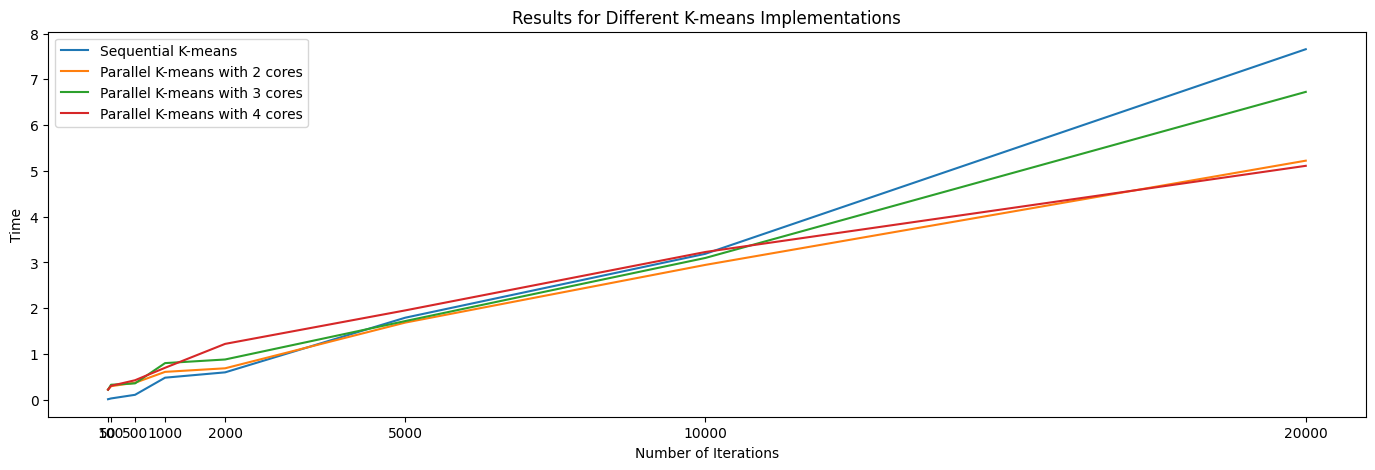

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming results1, results2, results3, and results4 are your data
iterations = [50, 100, 500, 1000, 2000, 5000, 10000, 20000]

plt.figure(figsize=(17, 5))
plt.plot(iterations, (results1), label="Sequential K-means")
plt.plot(iterations, (results2), label="Parallel K-means with 2 cores")
plt.plot(iterations, (results3), label="Parallel K-means with 3 cores")
plt.plot(iterations, (results4), label="Parallel K-means with 4 cores")
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('Time')
plt.title('Results for Different K-means Implementations')
plt.xticks(iterations)  # Set custom x-axis ticks
plt.show()


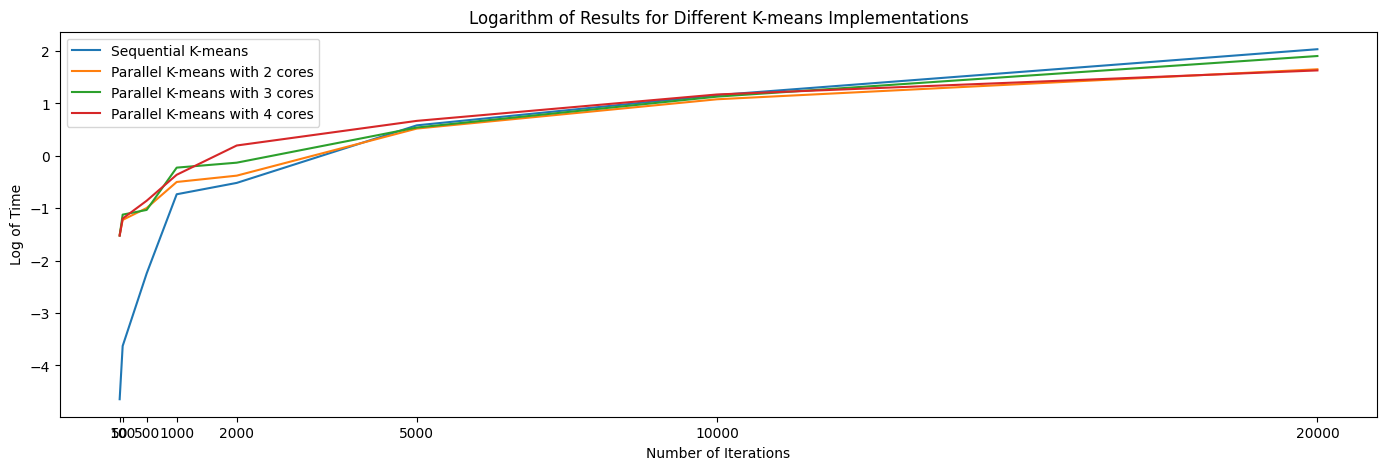

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming results1, results2, results3, and results4 are your data
iterations = [50, 100, 500, 1000, 2000, 5000, 10000, 20000]

plt.figure(figsize=(17, 5))
plt.plot(iterations, np.log(results1), label="Sequential K-means")
plt.plot(iterations, np.log(results2), label="Parallel K-means with 2 cores")
plt.plot(iterations, np.log(results3), label="Parallel K-means with 3 cores")
plt.plot(iterations, np.log(results4), label="Parallel K-means with 4 cores")
plt.legend()
plt.xlabel('Number of Iterations')
plt.ylabel('Log of Time')
plt.title('Logarithm of Results for Different K-means Implementations')
plt.xticks(iterations)  # Set custom x-axis ticks
plt.show()